# Spaceship Titanic - Training

## Importação das bibliotecas

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')


from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report

import graphviz


pd.set_option('display.max_columns', 25)

In [169]:
SEED = 6464

## Importação dos dados

In [170]:
spaceship = pd.read_csv('/home/franciscofoz/Documents/GitHub/machine-learning-training/Datasets/spaceship_titanic_train.csv')
spaceship

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


## Funções

In [171]:
def tabela_freq(df,variavel):
    
    df_freq = df.loc[:,[variavel]].value_counts().to_frame('freq').reset_index()
    df_percent = (df.loc[:,[variavel]].value_counts(normalize=True).to_frame('percent').round(3)*100).reset_index()
    df_freq_percent = pd.merge(df_freq,df_percent)
    return df_freq_percent


def roda_modelo(algoritmo):
    
    modelo = algoritmo()
    modelo.fit(train_x,train_y)
    previsoes = modelo.predict(test_x)

    y_pred = modelo.predict_proba(test_x)[:,1]
    fpr, tpr, _ = roc_curve(test_y, y_pred)
    roc_auc = auc(fpr, tpr)
    roc_auc

    return previsoes, roc_auc

def metricas_classificao(nome_modelo,predicao,auc):

  metricas = classification_report(test_y, predicao,output_dict=True)
  metricas = pd.DataFrame(metricas)
  df_metricas = pd.DataFrame({'AUC': auc,
                              'Acurácia' :  [metricas.iloc[0,2]],
                              'F1-score_1': [metricas.iloc[2,1]],
                              'Precisão':   [metricas.iloc[0,1]],
                              'Revocação':     [metricas.iloc[1,1]]},
                              index=[nome_modelo])
  
  return df_metricas


# Análise exploratória

In [172]:
spaceship_analise = spaceship.copy()

In [173]:
spaceship_analise.shape

(8693, 14)

In [174]:
# Verificar duplicatadas
spaceship_analise.duplicated().sum()

0

In [175]:
# Verificar valores nulos
spaceship_analise.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [176]:
#Percentual de valores nulos totais
spaceship_analise.isna().sum().sum()/len(spaceship_analise)*100


26.73415391694467

In [177]:
spaceship_analise.Transported.value_counts(normalize=True)

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64

In [178]:
for coluna in spaceship_analise.columns[1:-1]:
    print('\n',coluna)
    print('Sem valor nulo')
    print(round(spaceship_analise[spaceship_analise[coluna].isna()].Transported.value_counts(normalize=True),3).reset_index())
    print('\nCom valor nulo')
    print(round(spaceship_analise.Transported.value_counts(normalize=True),3).reset_index())
    print(21*'-')


 HomePlanet
Sem valor nulo
   Transported  proportion
0         True       0.512
1        False       0.488

Com valor nulo
   Transported  proportion
0         True       0.504
1        False       0.496
---------------------

 CryoSleep
Sem valor nulo
   Transported  proportion
0        False       0.512
1         True       0.488

Com valor nulo
   Transported  proportion
0         True       0.504
1        False       0.496
---------------------

 Cabin
Sem valor nulo
   Transported  proportion
0         True       0.503
1        False       0.497

Com valor nulo
   Transported  proportion
0         True       0.504
1        False       0.496
---------------------

 Destination
Sem valor nulo
   Transported  proportion
0         True       0.505
1        False       0.495

Com valor nulo
   Transported  proportion
0         True       0.504
1        False       0.496
---------------------

 Age
Sem valor nulo
   Transported  proportion
0         True       0.503
1        False    

In [179]:
# Percentual de sim e não no conjunto de dados
tabela_freq(spaceship_analise,'Transported')

,Transported,freq,percent
0,True,4378,50.4
1,False,4315,49.6


In [180]:
tabela_freq(spaceship_analise,'PassengerId')

,PassengerId,freq,percent
0,0001_01,1,0.0
1,6136_01,1,0.0
2,6141_01,1,0.0
3,6139_06,1,0.0
4,6139_05,1,0.0
...,...,...,...
8688,3126_01,1,0.0
8689,3124_03,1,0.0
8690,3124_02,1,0.0
8691,3124_01,1,0.0


In [181]:
passenger_id = spaceship_analise['PassengerId'].str.split('_',expand=True)
passenger_id.columns = ['id_passageiro','id_grupo']

In [182]:
tabela_freq(passenger_id,'id_passageiro')

,id_passageiro,freq,percent
0,4498,8,0.1
1,8168,8,0.1
2,8728,8,0.1
3,8796,8,0.1
4,8956,8,0.1
...,...,...,...
6212,3483,1,0.0
6213,3480,1,0.0
6214,3478,1,0.0
6215,3473,1,0.0


In [183]:
tabela_freq(passenger_id,'id_grupo')

,id_grupo,freq,percent
0,01,6217,71.5
1,02,1412,16.2
2,03,571,6.6
3,04,231,2.7
4,05,128,1.5
5,06,75,0.9
6,07,46,0.5
7,08,13,0.1


In [184]:
tabela_freq(spaceship_analise,'HomePlanet')

,HomePlanet,freq,percent
0,Earth,4602,54.2
1,Europa,2131,25.1
2,Mars,1759,20.7


In [185]:
tabela_freq(spaceship_analise,'CryoSleep')

,CryoSleep,freq,percent
0,False,5439,64.2
1,True,3037,35.8


In [186]:
tabela_freq(spaceship_analise,'Cabin')

,Cabin,freq,percent
0,G/734/S,8,0.1
1,C/21/P,7,0.1
2,G/1368/P,7,0.1
3,B/82/S,7,0.1
4,G/981/S,7,0.1
...,...,...,...
6555,F/1245/P,1,0.0
6556,F/1244/S,1,0.0
6557,F/1243/S,1,0.0
6558,F/1243/P,1,0.0


In [187]:
Cabin = spaceship_analise['Cabin'].str.split('/',expand=True)
Cabin.columns = ['deck','num','side']

In [188]:
tabela_freq(Cabin,'deck')

,deck,freq,percent
0,F,2794,32.9
1,G,2559,30.1
2,E,876,10.3
3,B,779,9.2
4,C,747,8.8
5,D,478,5.6
6,A,256,3.0
7,T,5,0.1


In [189]:
tabela_freq(Cabin,'num')

,num,freq,percent
0,82,28,0.3
1,86,22,0.3
2,19,22,0.3
3,176,21,0.2
4,97,21,0.2
...,...,...,...
1812,1685,1,0.0
1813,639,1,0.0
1814,1082,1,0.0
1815,1689,1,0.0


In [190]:
tabela_freq(Cabin,'side')

,side,freq,percent
0,S,4288,50.5
1,P,4206,49.5


In [191]:
tabela_freq(spaceship_analise,'Destination')

,Destination,freq,percent
0,TRAPPIST-1e,5915,69.5
1,55 Cancri e,1800,21.1
2,PSO J318.5-22,796,9.4


In [192]:
tabela_freq(spaceship_analise,'Age')

,Age,freq,percent
0,24.0,324,3.8
1,18.0,320,3.8
2,21.0,311,3.7
3,19.0,293,3.4
4,23.0,292,3.4
...,...,...,...
75,75.0,4,0.0
76,78.0,3,0.0
77,79.0,3,0.0
78,76.0,2,0.0


# TRANSFORMAR EM CATEGÓRICO

In [193]:
tabela_freq(spaceship_analise,'VIP')

,VIP,freq,percent
0,False,8291,97.7
1,True,199,2.3


In [194]:
tabela_freq(spaceship_analise,'RoomService')

,RoomService,freq,percent
0,0.0,5577,65.5
1,1.0,117,1.4
2,2.0,79,0.9
3,3.0,61,0.7
4,4.0,47,0.6
...,...,...,...
1268,902.0,1,0.0
1269,903.0,1,0.0
1270,906.0,1,0.0
1271,909.0,1,0.0


In [195]:
tabela_freq(spaceship_analise,'FoodCourt')

,FoodCourt,freq,percent
0,0.0,5456,64.1
1,1.0,116,1.4
2,2.0,75,0.9
3,3.0,53,0.6
4,4.0,53,0.6
...,...,...,...
1502,1314.0,1,0.0
1503,1319.0,1,0.0
1504,1320.0,1,0.0
1505,1327.0,1,0.0


In [196]:
tabela_freq(spaceship_analise,'ShoppingMall')

,ShoppingMall,freq,percent
0,0.0,5587,65.8
1,1.0,153,1.8
2,2.0,80,0.9
3,3.0,59,0.7
4,4.0,45,0.5
...,...,...,...
1110,741.0,1,0.0
1111,742.0,1,0.0
1112,745.0,1,0.0
1113,746.0,1,0.0


In [197]:
tabela_freq(spaceship_analise,'Spa')

,Spa,freq,percent
0,0.0,5324,62.6
1,1.0,146,1.7
2,2.0,105,1.2
3,3.0,53,0.6
4,5.0,53,0.6
...,...,...,...
1322,1012.0,1,0.0
1323,1013.0,1,0.0
1324,1019.0,1,0.0
1325,1027.0,1,0.0


In [198]:
tabela_freq(spaceship_analise,'VRDeck')

,VRDeck,freq,percent
0,0.0,5495,64.6
1,1.0,139,1.6
2,2.0,70,0.8
3,3.0,56,0.7
4,5.0,51,0.6
...,...,...,...
1301,952.0,1,0.0
1302,954.0,1,0.0
1303,956.0,1,0.0
1304,957.0,1,0.0


In [199]:
tabela_freq(spaceship_analise,'Name')

,Name,freq,percent
0,Keitha Josey,2,0.0
1,Juane Popelazquez,2,0.0
2,Elaney Webstephrey,2,0.0
3,Apix Wala,2,0.0
4,Glenna Valezaley,2,0.0
...,...,...,...
8468,Eriey Bartez,1,0.0
8469,Erie Woodwinez,1,0.0
8470,Erie Sextones,1,0.0
8471,Erie Rilley,1,0.0


In [200]:
spaceship_analise

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [201]:
tabela_freq(spaceship_analise,'Cabin')

,Cabin,freq,percent
0,G/734/S,8,0.1
1,C/21/P,7,0.1
2,G/1368/P,7,0.1
3,B/82/S,7,0.1
4,G/981/S,7,0.1
...,...,...,...
6555,F/1245/P,1,0.0
6556,F/1244/S,1,0.0
6557,F/1243/S,1,0.0
6558,F/1243/P,1,0.0


In [202]:
tabela_freq(spaceship_analise,'Destination')

,Destination,freq,percent
0,TRAPPIST-1e,5915,69.5
1,55 Cancri e,1800,21.1
2,PSO J318.5-22,796,9.4


In [203]:
tabela_freq(spaceship_analise,'VIP')

,VIP,freq,percent
0,False,8291,97.7
1,True,199,2.3


In [204]:
tabela_freq(spaceship_analise,'Name')

,Name,freq,percent
0,Keitha Josey,2,0.0
1,Juane Popelazquez,2,0.0
2,Elaney Webstephrey,2,0.0
3,Apix Wala,2,0.0
4,Glenna Valezaley,2,0.0
...,...,...,...
8468,Eriey Bartez,1,0.0
8469,Erie Woodwinez,1,0.0
8470,Erie Sextones,1,0.0
8471,Erie Rilley,1,0.0


In [205]:
variaveis_numericas = spaceship_analise[['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']]
variaveis_numericas.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


<AxesSubplot:>

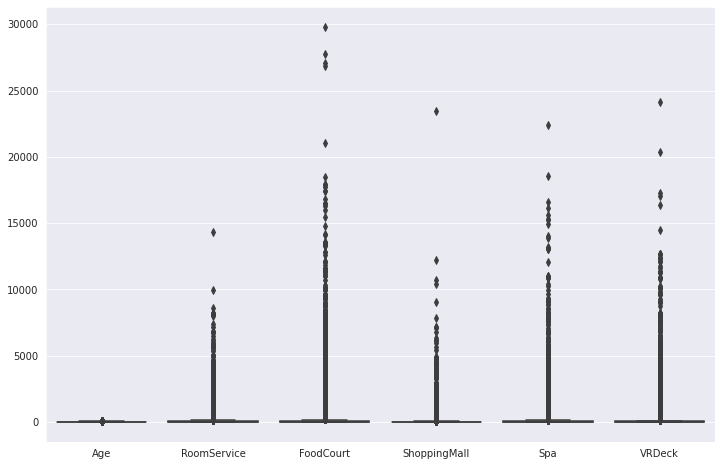

In [206]:
plt.figure(figsize=(12,8))
sns.boxplot(data=variaveis_numericas)

# Feature Engineering

In [207]:
spaceship_analise

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# 1 - ML Aleatório - Teste

In [208]:
spaceship_copia = spaceship.copy()
spaceship_copia.dropna(inplace=True)
spaceship_copia.shape

(6606, 14)

In [209]:
x = spaceship_copia.iloc[:,:-1]
y = spaceship_copia.iloc[:,-1]

In [210]:
df = pd.get_dummies(x, columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination','VIP','Name'])
df

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,...,Name_Zinon Oilloody,Name_Zinonon Frolestty,Name_Zinonon Veriedeezy,Name_Zinopus Spandisket,Name_Zinor Axlentindy,Name_Zinor Proorbeng,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Pasharne
0,0001_01,39.0,0.0,0.0,0.0,0.0,0.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
1,0002_01,24.0,109.0,9.0,25.0,549.0,44.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
2,0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
3,0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
4,0004_01,16.0,303.0,70.0,151.0,565.0,2.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
8689,9278_01,18.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
8690,9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False
8691,9280_01,32.0,0.0,1049.0,0.0,353.0,3235.0,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False


In [211]:
train_x,test_x,train_y,test_y = train_test_split(df,y,test_size=0.25, random_state=SEED)
print(train_x.shape)
print(train_y.shape)

(4954, 11912)
(4954,)


# 1 - Resultados

In [212]:
metricas_dummy = metricas_classificao('DummyClassifier',roda_modelo(DummyClassifier)[0],roda_modelo(DummyClassifier)[1])
metricas_dtc = metricas_classificao('DecisionTreeClassifier',roda_modelo(DecisionTreeClassifier)[0],roda_modelo(DecisionTreeClassifier)[1])
metricas_randomforest = metricas_classificao('RandomForestClassifier',roda_modelo(RandomForestClassifier)[0],roda_modelo(RandomForestClassifier)[1])
metricas_extratree = metricas_classificao('ExtraTreesClassifier',roda_modelo(ExtraTreesClassifier)[0],roda_modelo(ExtraTreesClassifier)[1])
metricas_bagging = metricas_classificao('BaggingClassifier',roda_modelo(BaggingClassifier)[0],roda_modelo(BaggingClassifier)[1])
metricas_knn = metricas_classificao('KNeighborsClassifier',roda_modelo(KNeighborsClassifier)[0],roda_modelo(KNeighborsClassifier)[1])
metricas_bnb = metricas_classificao('BernoulliNB',roda_modelo(BernoulliNB)[0],roda_modelo(BernoulliNB)[1])


metricas_modelos = pd.concat([metricas_dummy,metricas_dtc,metricas_randomforest,
                              metricas_extratree,metricas_bagging,metricas_knn,metricas_bnb])

metricas_modelos.sort_values(by='Acurácia',ascending=False)

/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,AUC,Acurácia,F1-score_1,Precisão,Revocação
BaggingClassifier,0.853910,0.786320,0.785931,0.797048,0.775120
RandomForestClassifier,0.855180,0.776634,0.773481,0.794451,0.753589
ExtraTreesClassifier,0.851041,0.762107,0.741617,0.823358,0.674641
DecisionTreeClassifier,0.751750,0.759080,0.762813,0.760095,0.765550
BernoulliNB,0.776341,0.724576,0.700066,0.779736,0.635167
KNeighborsClassifier,0.639936,0.601090,0.647782,0.585507,0.724880
DummyClassifier,0.500000,0.506053,0.672026,0.506053,1.000000


# 2 - ML Aleatório - Preenchimento dos valores

In [213]:
spaceship_2 = spaceship.copy()
spaceship_2 = spaceship_2.fillna(0)
spaceship_2.shape


(8693, 14)

In [214]:
x = spaceship_2.iloc[:,:-1]
y = spaceship_2.iloc[:,-1]

In [215]:
x = pd.get_dummies(x, columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination','VIP','Name'])
x

,PassengerId,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_0,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,...,Name_Zinonon Veriedeezy,Name_Zinopus Fuelddid,Name_Zinopus Spandisket,Name_Zinor Axlentindy,Name_Zinor Proorbeng,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne
0,0001_01,39.0,0.0,0.0,0.0,0.0,0.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
1,0002_01,24.0,109.0,9.0,25.0,549.0,44.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
2,0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
3,0003_02,33.0,0.0,1283.0,371.0,3329.0,193.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
4,0004_01,16.0,303.0,70.0,151.0,565.0,2.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,41.0,0.0,6819.0,0.0,1643.0,74.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
8689,9278_01,18.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False
8690,9279_01,26.0,0.0,0.0,1872.0,1.0,0.0,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False
8691,9280_01,32.0,0.0,1049.0,0.0,353.0,3235.0,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False,False,False


In [216]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3, random_state=SEED)
print(train_x.shape)
print(train_y.shape)

(6085, 15054)
(6085,)


# Resultados

In [217]:
metricas_dummy = metricas_classificao('DummyClassifier',roda_modelo(DummyClassifier)[0],roda_modelo(DummyClassifier)[1])
metricas_dtc = metricas_classificao('DecisionTreeClassifier',roda_modelo(DecisionTreeClassifier)[0],roda_modelo(DecisionTreeClassifier)[1])
metricas_randomforest = metricas_classificao('RandomForestClassifier',roda_modelo(RandomForestClassifier)[0],roda_modelo(RandomForestClassifier)[1])
metricas_extratree = metricas_classificao('ExtraTreesClassifier',roda_modelo(ExtraTreesClassifier)[0],roda_modelo(ExtraTreesClassifier)[1])
metricas_bagging = metricas_classificao('BaggingClassifier',roda_modelo(BaggingClassifier)[0],roda_modelo(BaggingClassifier)[1])
metricas_knn = metricas_classificao('KNeighborsClassifier',roda_modelo(KNeighborsClassifier)[0],roda_modelo(KNeighborsClassifier)[1])
metricas_bnb = metricas_classificao('BernoulliNB',roda_modelo(BernoulliNB)[0],roda_modelo(BernoulliNB)[1])


metricas_modelos = pd.concat([metricas_dummy,metricas_dtc,metricas_randomforest,
                              metricas_extratree,metricas_bagging,metricas_knn,metricas_bnb])

metricas_modelos.sort_values(by='Acurácia',ascending=False).round(3)

/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,AUC,Acurácia,F1-score_1,Precisão,Revocação
RandomForestClassifier,0.868,0.797,0.797,0.820,0.776
BaggingClassifier,0.865,0.789,0.791,0.808,0.775
ExtraTreesClassifier,0.854,0.770,0.755,0.838,0.686
DecisionTreeClassifier,0.770,0.766,0.773,0.774,0.771
BernoulliNB,0.791,0.742,0.725,0.800,0.663
KNeighborsClassifier,0.638,0.604,0.660,0.591,0.747
DummyClassifier,0.500,0.485,0.000,0.000,0.000


# 3 - ML Aleatório - Eliminando duplicatas


In [218]:
spaceship_3 = spaceship.copy()
spaceship_3 = spaceship.dropna()
print(spaceship_3.shape)

x = spaceship_2.iloc[:,:-1]
y = spaceship_2.iloc[:,-1]

x = pd.get_dummies(x, columns=['HomePlanet', 'CryoSleep', 'Cabin', 'Destination','VIP','Name'])

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3, random_state=SEED)
print(train_x.shape)
print(train_y.shape)

(6606, 14)
(6085, 15054)
(6085,)


# Resultados

In [219]:
metricas_dummy = metricas_classificao('DummyClassifier',roda_modelo(DummyClassifier)[0],roda_modelo(DummyClassifier)[1])
metricas_dtc = metricas_classificao('DecisionTreeClassifier',roda_modelo(DecisionTreeClassifier)[0],roda_modelo(DecisionTreeClassifier)[1])
metricas_randomforest = metricas_classificao('RandomForestClassifier',roda_modelo(RandomForestClassifier)[0],roda_modelo(RandomForestClassifier)[1])
metricas_extratree = metricas_classificao('ExtraTreesClassifier',roda_modelo(ExtraTreesClassifier)[0],roda_modelo(ExtraTreesClassifier)[1])
metricas_bagging = metricas_classificao('BaggingClassifier',roda_modelo(BaggingClassifier)[0],roda_modelo(BaggingClassifier)[1])
metricas_knn = metricas_classificao('KNeighborsClassifier',roda_modelo(KNeighborsClassifier)[0],roda_modelo(KNeighborsClassifier)[1])
metricas_bnb = metricas_classificao('BernoulliNB',roda_modelo(BernoulliNB)[0],roda_modelo(BernoulliNB)[1])


metricas_modelos = pd.concat([metricas_dummy,metricas_dtc,metricas_randomforest,
                              metricas_extratree,metricas_bagging,metricas_knn,metricas_bnb])

metricas_modelos.sort_values(by='Acurácia',ascending=False).round(3)

/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/franciscofoz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,AUC,Acurácia,F1-score_1,Precisão,Revocação
BaggingClassifier,0.864,0.793,0.795,0.811,0.780
RandomForestClassifier,0.872,0.790,0.791,0.810,0.773
ExtraTreesClassifier,0.856,0.771,0.755,0.838,0.687
DecisionTreeClassifier,0.770,0.762,0.769,0.769,0.770
BernoulliNB,0.791,0.742,0.725,0.800,0.663
KNeighborsClassifier,0.638,0.604,0.660,0.591,0.747
DummyClassifier,0.500,0.485,0.000,0.000,0.000
